<a href="https://colab.research.google.com/github/lowxuan215-lab/AmsterdamUMCdb/blob/master/bigquery/abgfrequencyheatmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_c4i_square.png?raw=1" alt="Logo C4I" width=128px/>

<img src="https://github.com/AmsterdamUMC/AmsterdamUMCdb/blob/master/img/logo_amds.png?raw=1" alt="Logo AMDS" width=128px/>

# AmsterdamUMCdb Van Gogh
## AmsterdamUMCdb - Freely Accessible ICU Database

AmsterdamUMCdb Van Gogh January 2026
Copyright &copy; 2003-2026 Amsterdam UMC - Amsterdam Medical Data Science


# Running Colab
If not done already, please open Colab with this **getting_started** notebook from the official AmsterdamUMCdb GitHub repository: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AmsterdamUMC/AmsterdamUMCdb/blob/master/bigquery/getting_started_v2.ipynb)

**Important**: when following this tutorial, make sure to follow *all* steps and to run the **code cells** using the **Play** button or by pressing `Ctrl-Enter`

# Before you Begin
Ensure you have a working Google account and verify that the e-mail address used when applying for access has been associated with this account. If you already have a Google account, you can add secondary e-mail addresses [here](https://myaccount.google.com/alternateemail), or alternatively create another Google account using the e-mail address used in the application form.

If you don't have any experience in using Jupyter notebooks and/or Python, it is recommended to familiarize yourself with the [basics](https://colab.research.google.com/notebooks/intro.ipynb).

# Accessing the database
To explore and query the database you need to create a Google Cloud Platform project. For new users, Google offers a free tier of 1 TB (2<sup>40</sup> bytes) per month for queries and in addition \$300 credit for free for use on the Google Cloud Platform (currently: \$6.00 per TB). In the unlikely event, this amount is not sufficient during a datathon or course, please contact us and we will work with you to find a solution.

# Signing up for Google Cloud Platform
- To sign up for the free tier and free credits, please visit the Google Cloud Platform: https://cloud.google.com/.
- Click **Get started for free**.
- Log in with the Google account you used when registering for the datathon.
- In Step 1 of 2: agree to the **Terms of Service** and select **Continue**.
- In Step 2 of 2: You will be required to add some additional information, including a payment method to make sure you are not a robot. Don't worry you won't be charged unless you manually upgrade to a paid account. Depending on your payment provider, you may have an additional step to verify the payment method.
- Finally press **Start my free trial**. You are good to go.



<a name="cell-project-id"></a>
# Retrieving your Google Cloud Project ID
- At the top of the screen, select **My First Project** or [create a new one](https://console.cloud.google.com/projectcreate). Please write down the Project ID in the cell below ("Insert text here") and **Run** the cell to store the value.

In [1]:
# sets *your* project id
PROJECT_ID = "project-b94b02e0-ce53-4cd7-9a8" #@param {type:"string"}

# Sets the default BigQuery dataset for accessing AmsterdamUMCdb

If you have received instructions to use a specific BigQuery instance, change the default settings here. Otherwise use these default values.

In [2]:
# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'van_gogh_2026_datathon' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

# Provide your credentials to access the AmsterdamUMCdb dataset on Google BigQuery
Authenticate your credentials with Google Cloud Platform and set your default Google Cloud Project ID as an environment variable for running query jobs.

1. Run the cell. The `Allow this notebook to access your Google credentials?` prompt appears. Select `Allow`.
2. In the `Sign in - Google Accounts` dialog, use the account you registered during the AmsterdamUMCdb application process and select `Allow` again.

In [3]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')

Authenticated


# Google BigQuery costs
Since BiqQuery uses a [columnar data structure](https://en.wikipedia.org/wiki/Column-oriented_DBMS), Google will charge you according to the columns selected and the size of the data in those columns. Especially in the data exploration phase, it is prudent to query only the columns you will be actually needing for the analysis.

The tables have also been [clustered](https://cloud.google.com/bigquery/docs/clustered-tables) on `<domain>_concept_id`, `person_id`, and `<domain>_datetime`. By filtering using WHERE on these columns (in the above order), you can reduce the processing costs as well. By filtering using WHERE, you can reduce the processing costs as well.

Some examples:

`SELECT * FROM measurements` will process about 31.5 GiB data, whereas

`SELECT person_id, measurement_concept_id, measurement_datetime, value_as_number FROM FROM measurement` will process around 11.51 GiB.

**Important**: `LIMIT` or `WHERE` clauses on columns that have not been used in partitioning or clustering of the data do not have **any** effect on reducing the amount of data processed, and thus charged. These clauses will only limit the number of records returned by the query.

# Available documentation for AmsterdamUMCdb tables.
Since the migration to the OMOP Common Data Model, the official documentation for all tables can be found [here](https://ohdsi.github.io/CommonDataModel/cdm54.html).

# Enable data table display

Colab includes the `google.colab.data_table` package that can be used to display Pandas dataframes as an interactive data table (default limits: `max_rows = 20000`, `max_columns = 20`). This is especially useful when exploring the  tables or dictionary from AmsterdamUMCdb. It can be enabled with:

In [4]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 50
DataTable.max_rows = 80000

# Running your first query on AmsterdamUMCdb
BigQuery provides different ways to query the dataset:
- **magics**: the `bigquery_magics` library includes a `%%bigquery` *magic* command which runs a query and either displays the result or saves it to a Pandas DataFrame. The main advantage of this technique is that it improves readability of SQL code by syntax highlighting. Its main limitation: it requires a separate cell for the query, so cannot be combined with other Python code in the same code cell.

Let's query the `person` table using magics.



## Set the default query job configuration for magics

In [5]:
%load_ext bigquery_magics
from bigquery_magics import bigquery_magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
bigquery_magics.context.default_query_job_config = def_config

## Query the `person` table and copy the data to the `persons` Pandas dataframe:

The `person` table contains a record for each patient in AmsterdamUMCdb.

Since this is a relatively small table, it is acceptable to use `SELECT *`.

**Note**: Should an error occur while running the query, please see
the AmsterdamUMCdb BigQuery [Frequently Asked Questions](https://github.com/AmsterdamUMC/AmsterdamUMCdb/wiki/bigquery#faq).

In [6]:
%%bigquery person
SELECT * FROM person

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
%%bigquery abg_times
SELECT
    -- Extract the Day of the Week (1=Sunday, 2=Monday, ..., 7=Saturday)
    EXTRACT(DAYOFWEEK FROM m.measurement_datetime) as day_of_week,

    -- Extract the Hour of the Day (0-23)
    EXTRACT(HOUR FROM m.measurement_datetime) as hour_of_day,

    -- Count the number of ABGs in each time slot
    COUNT(*) as abg_count

FROM `measurement` m
JOIN `visit_occurrence` v ON m.person_id = v.person_id
WHERE
    -- Filter for Arterial pH (the primary marker for an ABG)
    m.measurement_concept_id = 3019977

    -- Filter for measurements taken between Day 2 and Day 7 of the admission
    AND m.measurement_datetime BETWEEN
        TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 2 DAY)
        AND TIMESTAMP_ADD(v.visit_start_datetime, INTERVAL 7 DAY)

    -- Ensure the measurement is within the actual visit window
    AND m.measurement_datetime <= v.visit_end_datetime

GROUP BY 1, 2
ORDER BY 1, 2

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
abg_times

,day_of_week,hour_of_day,abg_count
0,1,0,424
1,1,1,381
2,1,2,419
3,1,3,383
4,1,4,370
...,...,...,...
163,7,19,728
164,7,20,797
165,7,21,775
166,7,22,818


NameError: name 'np' is not defined

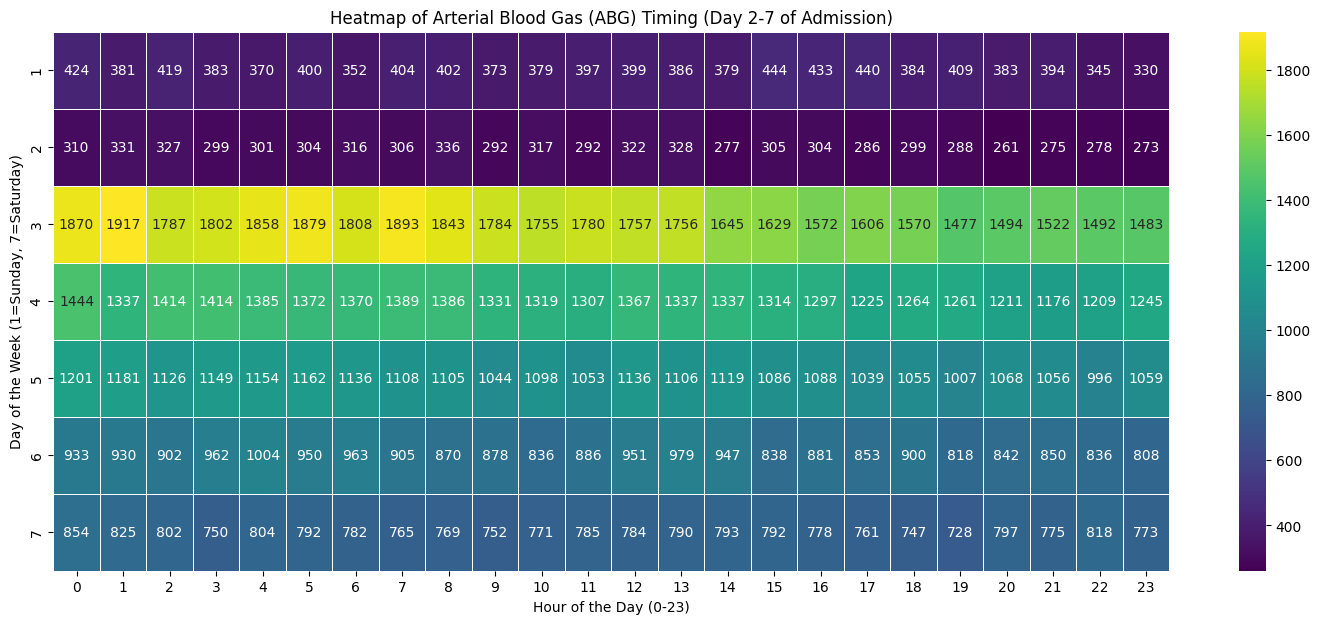

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# (Assuming 'abg_times' is the DataFrame from your SQL query)

# 1. Pivot the data to create a 2D matrix for the heatmap
heatmap_data = abg_times.pivot(
    index='day_of_week',
    columns='hour_of_day',
    values='abg_count'
).fillna(0)

# *** THE FIX: Convert the entire DataFrame to a numeric type ***
heatmap_data = heatmap_data.astype(float)

# 2. Create the Heatmap
plt.figure(figsize=(18, 7))
sns.heatmap(
    heatmap_data,
    cmap='viridis',
    linewidths=.5,
    annot=True,
    fmt=".0f"   # Format numbers as integers
)

# 3. Formatting and Labels
plt.title("Heatmap of Arterial Blood Gas (ABG) Timing (Day 2-7 of Admission)")
plt.xlabel("Hour of the Day (0-23)")
plt.ylabel("Day of the Week (1=Sunday, 7=Saturday)")
# Optional: Rename y-axis labels for clarity
day_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
# Ensure the ticks align with the data's index (1-7)
plt.yticks(ticks=np.arange(0.5, 7.5), labels=day_names, rotation=0)

plt.show()